In [1]:
# un poco menos de warnings de tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# de python, para especificar rutas de archivos y directorios
from pathlib import Path

# lib para trabajar con arrays
import numpy as np

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# pandas
import pandas as pd

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import MobileNetV2

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

In [2]:
path = '/home/usuario/CelebFaces/'

# Construir las rutas completas para cada archivo
list_attr_celeba = os.path.join(path, 'list_attr_celeba.csv')
list_eval_partition = os.path.join(path, 'list_eval_partition.csv')
img_align_celeba = os.path.join(path, 'img_align_celeba/img_align_celeba')

# Cargar el archivo de atributos
df_atributos = pd.read_csv(list_attr_celeba)

# Cargar el archivo de partición
df_particiones  = pd.read_csv(list_eval_partition)

## Volumetría de datos

In [3]:
df_atributos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   image_id             202599 non-null  object
 1   5_o_Clock_Shadow     202599 non-null  int64 
 2   Arched_Eyebrows      202599 non-null  int64 
 3   Attractive           202599 non-null  int64 
 4   Bags_Under_Eyes      202599 non-null  int64 
 5   Bald                 202599 non-null  int64 
 6   Bangs                202599 non-null  int64 
 7   Big_Lips             202599 non-null  int64 
 8   Big_Nose             202599 non-null  int64 
 9   Black_Hair           202599 non-null  int64 
 10  Blond_Hair           202599 non-null  int64 
 11  Blurry               202599 non-null  int64 
 12  Brown_Hair           202599 non-null  int64 
 13  Bushy_Eyebrows       202599 non-null  int64 
 14  Chubby               202599 non-null  int64 
 15  Double_Chin          202599 non-nu

In [4]:
df_atributos

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
202595,202596.jpg,-1,-1,-1,-1,-1,1,1,-1,-1,...,-1,1,1,-1,-1,-1,-1,-1,-1,1
202596,202597.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
202597,202598.jpg,-1,1,1,-1,-1,-1,1,-1,1,...,-1,1,-1,1,1,-1,1,-1,-1,1


In [5]:
print("Cantidad de imágenes: ", len(df_atributos.image_id))
print("Cantidad de atributos: ", df_atributos.shape[1])

Cantidad de imágenes:  202599
Cantidad de atributos:  41


In [6]:
df_atributos = df_atributos[['image_id', 'No_Beard']]
df_atributos['No_Beard'] = df_atributos['No_Beard'].replace({1 : 0, -1 : 1 }) 
df_atributos["No_Beard"] = df_atributos["No_Beard"].astype(str)
merged = pd.merge(df_particiones, df_atributos, on='image_id')

/tmp/ipykernel_3924/4131797412.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_atributos['No_Beard'] = df_atributos['No_Beard'].replace({1 : 0, -1 : 1 })
/tmp/ipykernel_3924/4131797412.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_atributos["No_Beard"] = df_atributos["No_Beard"].astype(str)


In [7]:
train = merged[merged['partition'] == 0]
val = merged[merged['partition'] == 1]
test = merged[merged['partition'] == 2]

In [8]:
train = train.drop('partition', axis=1)
val = val.drop('partition', axis=1)
test = test.drop('partition', axis=1)

<Axes: xlabel='No_Beard'>

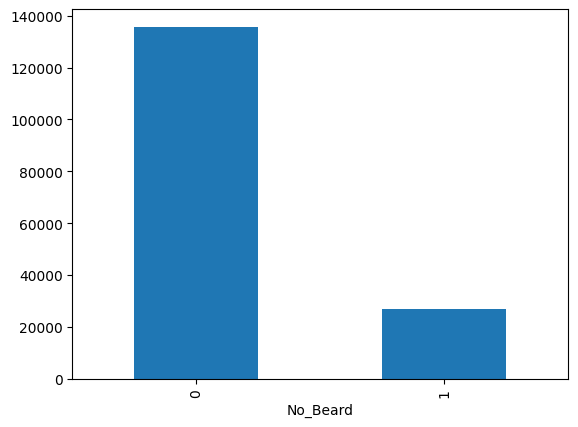

In [9]:
train["No_Beard"].value_counts().plot.bar()

In [10]:
SIZE = 128
train_datagen = ImageDataGenerator(rescale=1./255)

train = train_datagen.flow_from_dataframe(
    train, 
    img_align_celeba + "/", 
    x_col='image_id',
    y_col='No_Beard',
    target_size=(SIZE, SIZE),
    class_mode='binary'
)

Found 162770 validated image filenames belonging to 2 classes.


In [11]:
val_datagen = ImageDataGenerator(rescale=1./255)

val = val_datagen.flow_from_dataframe(
    val, 
    img_align_celeba + "/", 
    x_col='image_id',
    y_col='No_Beard',
    target_size=(SIZE, SIZE),
    class_mode='binary',
)

Found 19867 validated image filenames belonging to 2 classes.


In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)

test = test_datagen.flow_from_dataframe(
    test, 
    img_align_celeba + "/",  
    x_col='image_id',
    y_col=None,
    target_size=(SIZE, SIZE),
    class_mode=None
)

Found 19962 validated image filenames.


In [13]:
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    images, labels = dataset.next()
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        #plt.title(dataset.No_Beard)
        plt.axis("off")

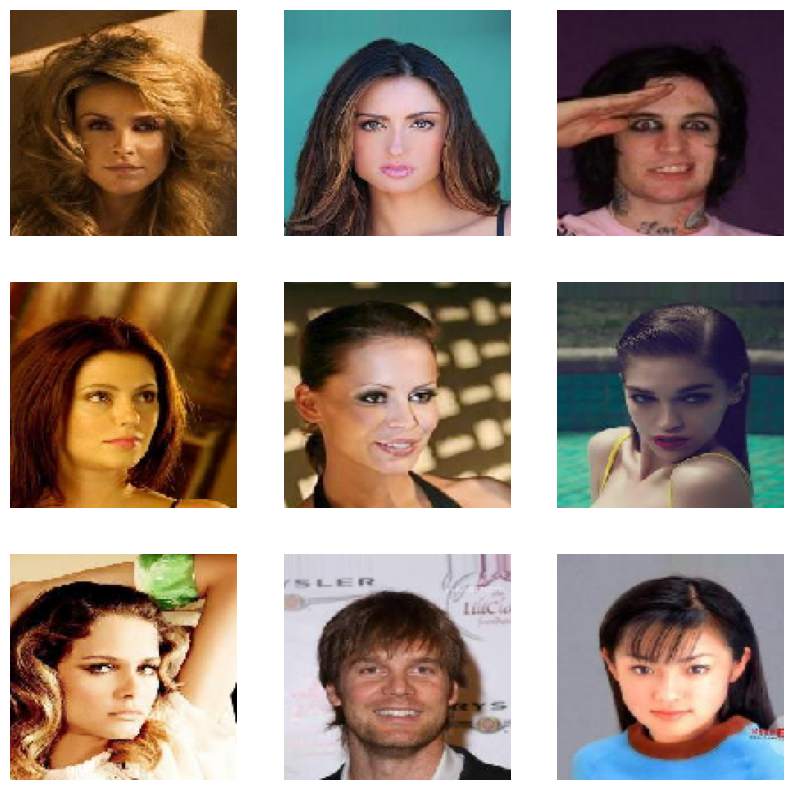

In [14]:
sample_images(train)

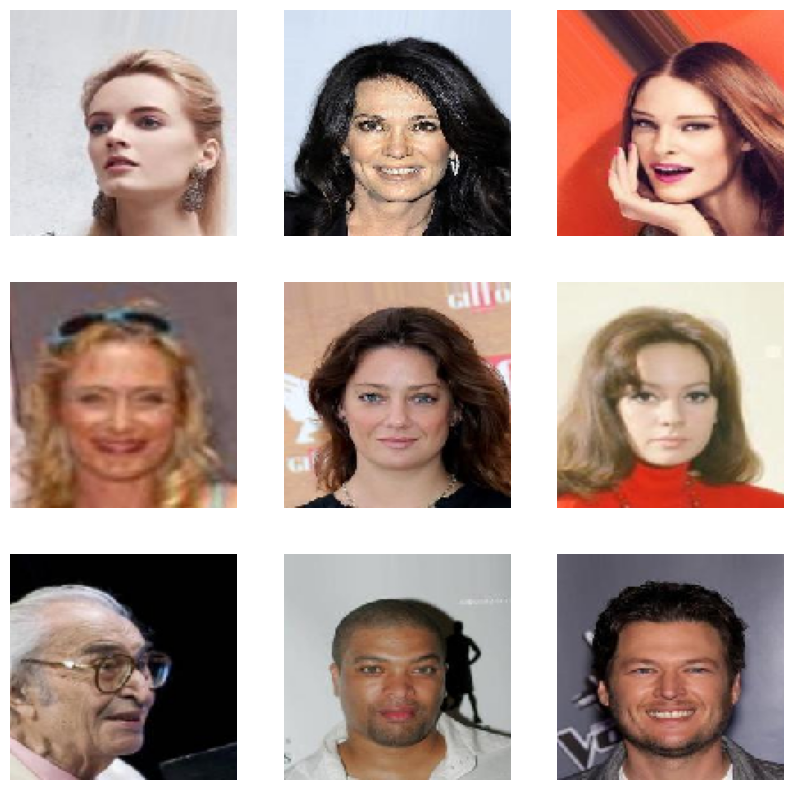

In [15]:
sample_images(val)

In [16]:
input_shape = (SIZE, SIZE, 3)

In [22]:
# MLP simple
model = Sequential([
    Flatten(input_shape=input_shape,),

    Dense(128, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 49152)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               6291584   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6,291,713
Trainable params: 6,291,713
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [25]:
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

In [26]:
history = model.fit(
    train,
    epochs=15,
    batch_size=128,
    validation_data=val,
    callbacks=[OurCustomCallback()]
)

Epoch 1/15
 291/5087 [>.............................] - ETA: 29:23 - loss: 1.0928 - accuracy: 0.8196

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()